In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

plt.rcParams.update({
    'font.size': 16,          # Base font size
})
bohr_to_angstrom = 0.52917721067

# Path to your repo (adjust this)
repo_path = "/home/x_pamca/postdoc_proj/EMTO_input_automation"

# Add it to sys.path if not already there
if repo_path not in sys.path:
    sys.path.append(repo_path)

#from modules.create_files import create_kstr_input, create_shape_input, create_kgrn_input, create_kfcd_input, create_job_ca, create_job_volume, create_eos_input

from modules.create_files import *

In [2]:
def read_file(name):

    with open(name, "r") as f:
        lines = f.readlines()

    return lines

# FePt

##### __Experimental lattice parameters__
```text
a = b = 3.86 Å
c = 3.76 Å
```
##### __Lattice vectors__
```text
1.00000000	0.00000000	0.00000000
0.00000000	1.00000000	0.00000000
0.00000000	0.00000000	0.97409326
```

##### __Atomic positions__
```text
        0.00000000      0.50000000      0.48704663
        0.50000000      0.00000000      0.48704663
        0.00000000      0.00000000      0.00000000
        0.50000000      0.50000000      0.00000000
```

# Create input files for different c/a ratios

In [ ]:
initial_ratio = 3.76 / 3.86
fractional_coors = np.array([[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, 0.0]])

ratios = np.linspace(initial_ratio - 3*0.02, initial_ratio + 3*0.02, 7)

# Subfolders to create inside each ratio folder
subfolders = ['smx', 'shp', 'pot', 'chd', 'fcd']

ratio_folder = "ratio_ca"
os.makedirs(ratio_folder, exist_ok=True)

for subfolder in subfolders:
    subfolder_path = os.path.join(ratio_folder, subfolder)
    os.makedirs(subfolder_path, exist_ok=True)

for i in ratios:

    lattice_vectors =  np.array([[1.0,  0.0, 0.0], [0.0,  1.0, 0.0], [0.0,  0.0, i]])
    cart_coords = fractional_coors @ lattice_vectors

    create_kstr_input(
    filename=f"{ratio_folder}/smx/fept_{i:.2f}.dat",
    job_name=f"fept_{i:.2f}",
    NL=3,
    NQ3=4,
    A=1.0,
    B=1.0,
    C=i,
    DMAX=1.8265,
    LAT=5,
    lattice_vectors=lattice_vectors,
    lattice_positions=cart_coords,
)
    create_shape_input(
    filename=f"{ratio_folder}/shp/fept_{i:.2f}.dat",
    job_name=f"fept_{i:.2f}",
    smx_file=f"../smx/fept_{i:.2f}.tfh",
    NQ3=4,
)
    create_kgrn_input(
    filename=f"{ratio_folder}/fept_{i:.2f}.dat",
    job_name=f"fept_{i:.2f}",
    SWS=2.8267,
    smx_tfh_file=f"./smx/fept_{i:.2f}.tfh",
    smx_mdl_file=f"./smx/fept_{i:.2f}.mdl",
    shp_file=f"./shp/fept_{i:.2f}.shp",
)
    create_kfcd_input(
    filename=f"{ratio_folder}/fcd/fept_{i:.2f}.dat",
    job_name=f"fept_{i:.2f}",
    shp_file=f"../shp/fept_{i:.2f}.shp",
)
    
    create_job_ca(
    folder=f"{i:.2f}",
    filename=f"{ratio_folder}/run_fept_{i:.2f}.sh",
)
    

# Parse energy results

In [7]:
initial_ratio = 3.76 / 3.86
ratios = np.linspace(initial_ratio - 3*0.02, initial_ratio + 3*0.02, 7)

energies_lda = []
energies_gga = []

for i in ratios:
    out = read_file(f"ratio_ca/fcd/fept_{i:.2f}.prn")

    for line in out:
        if "TOT-LDA" in line:
            energies_lda.append(float(line.split()[1]))

        if "TOT-GGA" in line:
            energies_gga.append(float(line.split()[1]))

## Fit EOS (pymatgen)

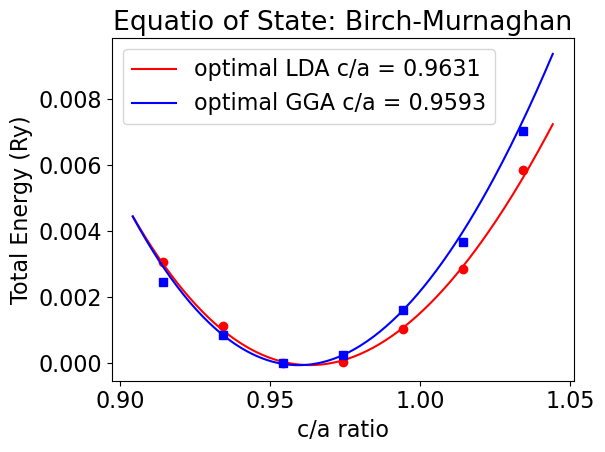

In [11]:
from pymatgen.analysis.eos import EOS


eos = EOS(eos_name='birch_murnaghan')
eos_fit_lda = eos.fit(ratios, energies_lda)
eos_fit_gga = eos.fit(ratios, energies_gga)

# print("V0 =", eos_fit.v0)
# print("B0 =", eos_fit.b0)
# print("B1 =", eos_fit.b1)
# print("E0 =", eos_fit.e0)

# Plot
xfit = np.linspace(ratios.min() - 0.01, ratios.max() + 0.01, 200)

e_fit_lda = eos_fit_lda.func(xfit)
e_fit_gga = eos_fit_gga.func(xfit)

plt.plot(ratios, np.array(energies_lda)-min(energies_lda), 'or')
plt.plot(xfit, e_fit_lda - min(energies_lda), '-r', label='optimal LDA c/a = {:.4f}'.format(eos_fit_lda.v0))
plt.plot(ratios, np.array(energies_gga)-min(energies_gga), 'sb')
plt.plot(xfit, e_fit_gga - min(energies_gga), '-b', label='optimal GGA c/a = {:.4f}'.format(eos_fit_gga.v0))

plt.xlabel('c/a ratio')
plt.ylabel('Total Energy (Ry)')             
plt.legend()
plt.title('Equatio of State: Birch-Murnaghan')
plt.tight_layout()
plt.show()


## Fit EOS (EMTO)

In [4]:
create_eos_input(
    filename="ratio_ca/eos_lda.dat",
    job_name="eos_lda",
    comment="Fe, bcc, D = 2.66, PBE-LDA, EMTO-FCD, no Ew.",
    R_or_V_data=list(ratios),
    Energy_data=list(energies_lda)
)

create_eos_input(
    filename="ratio_ca/eos_gga.dat",
    job_name="eos_gga",
    comment="Fe, bcc, D = 2.66, PBE-LDA, EMTO-FCD, no Ew.",
    R_or_V_data=list(ratios),
    Energy_data=list(energies_gga)
)

EOS input file 'ratio_ca/eos_lda.dat' created successfully.
EOS input file 'ratio_ca/eos_gga.dat' created successfully.


Equilibrium c/a for GGA = 0.9590
Minimum Energy for GGA= -78878.950763 eV
Equilibrium c/a for LDA = 0.9648
Minimum Energy for LDA= -78828.981174 eV


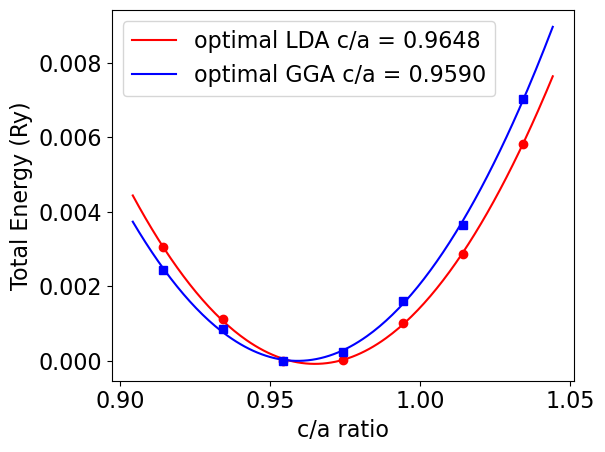

In [12]:
# Fit a quadratic polynomial: E = a*x^2 + b*x + c
ca_eq_lda, ene_eq_lda, coeffs_lda  = compute_equilibrium_ca(ratios, energies_lda)
ca_eq_gga, ene_eq_gga, coeffs_gga = compute_equilibrium_ca(ratios, energies_gga)


print(f"Equilibrium c/a for GGA = {ca_eq_gga:.4f}")
print(f"Minimum Energy for GGA= {ene_eq_gga:.6f} eV")

print(f"Equilibrium c/a for LDA = {ca_eq_lda:.4f}")
print(f"Minimum Energy for LDA= {ene_eq_lda:.6f} eV")


# Plot
xfit = np.linspace(ratios.min() - 0.01, ratios.max() + 0.01, 200)
efit_lda = np.polyval(coeffs_lda, xfit)
efit_gga = np.polyval(coeffs_gga, xfit)

plt.plot(ratios, np.array(energies_lda)-min(energies_lda), 'or')
plt.plot(xfit, efit_lda - min(energies_lda), '-r', label='optimal LDA c/a = {:.4f}'.format(ca_eq_lda))
plt.plot(ratios, np.array(energies_gga)-min(energies_gga), 'sb')
plt.plot(xfit, efit_gga - min(energies_gga), '-b', label='optimal GGA c/a = {:.4f}'.format(ca_eq_gga))

plt.xlabel('c/a ratio')
plt.ylabel('Total Energy (Ry)')             
plt.legend()
plt.tight_layout()
plt.show()


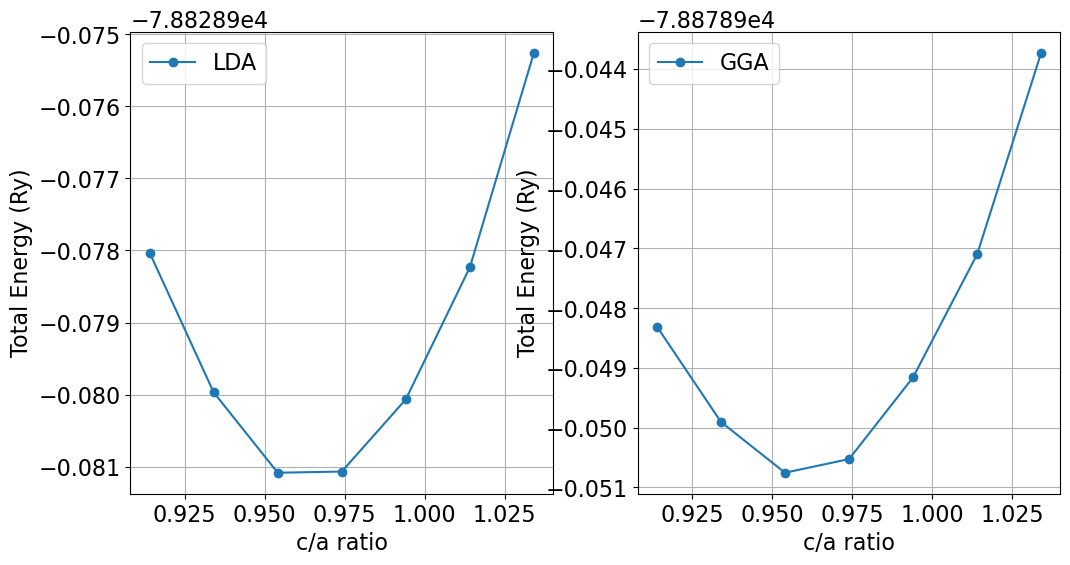

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # width=10, height=4 inches

ax1.plot(ratios, energies_lda, marker='o', label='LDA')
ax1.set_xlabel('c/a ratio')
ax1.set_ylabel('Total Energy (Ry)')
ax1.legend()
ax1.grid()

ax2.plot(ratios, energies_gga, marker='o', label='GGA')
ax2.set_xlabel('c/a ratio')
ax2.set_ylabel('Total Energy (Ry)')
ax2.legend()
ax2.grid()

plt.show()


# Volume optimization

In [3]:
a = 3.86
optimal_ca = 0.9646370092
volume = optimal_ca*a*a*a
volume_per_atom = volume / 4  # 4 atoms in the unit cell
sws_opt = (3*volume_per_atom/4/np.pi) ** (1/3)/bohr_to_angstrom

fractional_coors = np.array([[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, 0.0]])

ratios = np.linspace(sws_opt - 3*0.05, sws_opt + 3*0.05, 7)

# Subfolders to create inside each ratio folder
subfolders = ['smx', 'shp', 'pot', 'chd', 'fcd']

ratio_folder = "volume"
os.makedirs(ratio_folder, exist_ok=True)

for subfolder in subfolders:
    subfolder_path = os.path.join(ratio_folder, subfolder)
    os.makedirs(subfolder_path, exist_ok=True)

for i in ratios:

    lattice_vectors =  np.array([[1.0,  0.0, 0.0], [0.0,  1.0, 0.0], [0.0,  0.0, optimal_ca]])
    cart_coords = fractional_coors @ lattice_vectors

    create_kstr_input(
    filename=f"{ratio_folder}/smx/fept.dat",
    job_name=f"fept",
    NL=3,
    NQ3=4,
    A=1.0,
    B=1.0,
    C=i,
    DMAX=1.8265,
    LAT=5,
    lattice_vectors=lattice_vectors,
    lattice_positions=cart_coords,
)
    create_shape_input(
    filename=f"{ratio_folder}/shp/fept.dat",
    job_name=f"fept",
    smx_file=f"../smx/fept.tfh",
    NQ3=4,
)
    create_kgrn_input(
    filename=f"{ratio_folder}/fept_{i:.4f}.dat",
    job_name=f"fept_{i:.4f}",
    SWS=f"{i:.4f}",
    smx_tfh_file=f"./smx/fept.tfh",
    smx_mdl_file=f"./smx/fept.mdl",
    shp_file=f"./shp/fept.shp",
)
    create_kfcd_input(
    filename=f"{ratio_folder}/fcd/fept_{i:.4f}.dat",
    job_name=f"fept_{i:.4f}",
    name="fept",
    shp_file=f"../shp/fept.shp",
)
    
    
create_job_volume(
    name="fept",
    filename=f"{ratio_folder}/run_fept.sh",
    volumes=" ".join([f"{j:.4f}" for j in ratios])
)

KSTR input file 'volume/smx/fept.dat' created successfully.
SHAPE input file 'volume/shp/fept.dat' created successfully.
KGRN input file 'volume/fept_2.6666.dat' created successfully.
KFCD input file 'volume/fcd/fept_2.6666.dat' created successfully.
KSTR input file 'volume/smx/fept.dat' created successfully.
SHAPE input file 'volume/shp/fept.dat' created successfully.
KGRN input file 'volume/fept_2.7166.dat' created successfully.
KFCD input file 'volume/fcd/fept_2.7166.dat' created successfully.
KSTR input file 'volume/smx/fept.dat' created successfully.
SHAPE input file 'volume/shp/fept.dat' created successfully.
KGRN input file 'volume/fept_2.7666.dat' created successfully.
KFCD input file 'volume/fcd/fept_2.7666.dat' created successfully.
KSTR input file 'volume/smx/fept.dat' created successfully.
SHAPE input file 'volume/shp/fept.dat' created successfully.
KGRN input file 'volume/fept_2.8166.dat' created successfully.
KFCD input file 'volume/fcd/fept_2.8166.dat' created successful

In [6]:
energies_lda = []
energies_gga = []

for i in ratios:
    out = read_file(f"volume/fcd/fept_{i:.4f}.prn")

    for line in out:
        if "TOT-LDA" in line:
            energies_lda.append(float(line.split()[1]))

        if "TOT-GGA" in line:
            energies_gga.append(float(line.split()[1]))

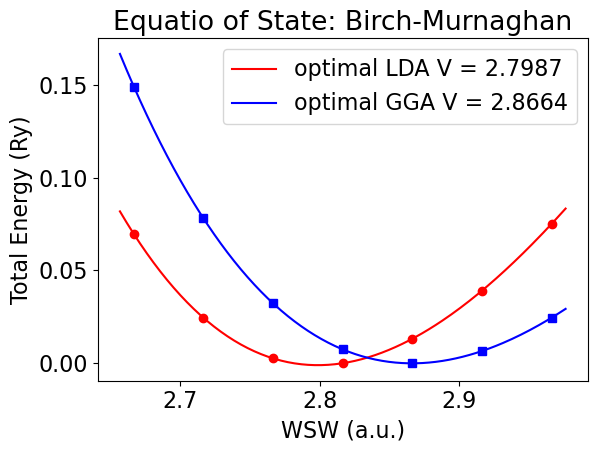

In [16]:
from pymatgen.analysis.eos import EOS


eos = EOS(eos_name='birch_murnaghan')
eos_fit_lda = eos.fit(ratios, energies_lda)
eos_fit_gga = eos.fit(ratios, energies_gga)

# print("V0 =", eos_fit.v0)
# print("B0 =", eos_fit.b0)
# print("B1 =", eos_fit.b1)
# print("E0 =", eos_fit.e0)

# Plot
xfit = np.linspace(ratios.min() - 0.01, ratios.max() + 0.01, 200)

e_fit_lda = eos_fit_lda.func(xfit)
e_fit_gga = eos_fit_gga.func(xfit)

plt.plot(ratios, np.array(energies_lda)-min(energies_lda), 'or')
plt.plot(xfit, e_fit_lda - min(energies_lda), '-r', label='optimal LDA V = {:.4f}'.format(eos_fit_lda.v0))
plt.plot(ratios, np.array(energies_gga)-min(energies_gga), 'sb')
plt.plot(xfit, e_fit_gga - min(energies_gga), '-b', label='optimal GGA V = {:.4f}'.format(eos_fit_gga.v0))

plt.xlabel('WSW (a.u.)')
plt.ylabel('Total Energy (Ry)')             
plt.legend()
plt.title('Equatio of State: Birch-Murnaghan')
plt.tight_layout()
plt.show()

In [15]:
((3*98.6793)/(4*np.pi))**(1/3)

2.8666795628015582